### Regression Project: Boston House Prices
ref.: https://github.com/gecso75/data/blob/main/housing.desc

#### Load libraries

In [21]:
import requests
import io
import numpy
from numpy import arange
from matplotlib import pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import set_option
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

#### Load dataset

In [2]:
url = "https://raw.githubusercontent.com/gecso75/data/main/housing.csv"
download = requests.get(url).content
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = read_csv(io.StringIO(download.decode('utf-8')), delim_whitespace=True, names=names)

#### Summarize Data

In [3]:
df.shape

(506, 14)

In [4]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

all features are numeric

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [7]:
set_option('precision', 3)
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653,22.533
std,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.886,45.025,2.100,4.000,279.000,17.400,375.377,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,391.440,11.360,21.200
75%,3.677,12.500,18.100,0.000,0.624,6.623,94.075,5.188,24.000,666.000,20.200,396.225,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.127,24.000,711.000,22.000,396.900,37.970,50.000


#### Data visualizations

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021E0C864788>,
      dtype=object)

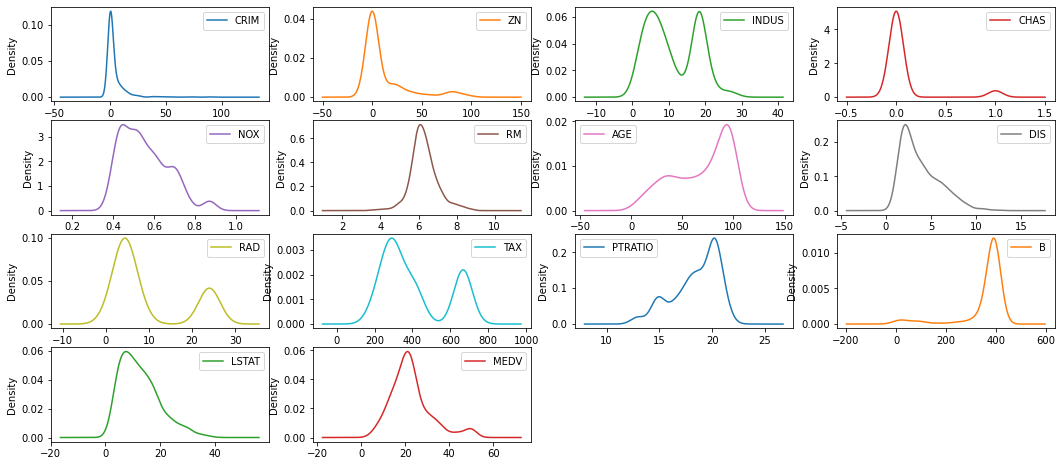

In [9]:
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, figsize=(18, 8))

CRIM           AxesSubplot(0.125,0.71587;0.168478x0.16413)
ZN          AxesSubplot(0.327174,0.71587;0.168478x0.16413)
INDUS       AxesSubplot(0.529348,0.71587;0.168478x0.16413)
CHAS        AxesSubplot(0.731522,0.71587;0.168478x0.16413)
NOX           AxesSubplot(0.125,0.518913;0.168478x0.16413)
RM         AxesSubplot(0.327174,0.518913;0.168478x0.16413)
AGE        AxesSubplot(0.529348,0.518913;0.168478x0.16413)
DIS        AxesSubplot(0.731522,0.518913;0.168478x0.16413)
RAD           AxesSubplot(0.125,0.321957;0.168478x0.16413)
TAX        AxesSubplot(0.327174,0.321957;0.168478x0.16413)
PTRATIO    AxesSubplot(0.529348,0.321957;0.168478x0.16413)
B          AxesSubplot(0.731522,0.321957;0.168478x0.16413)
LSTAT            AxesSubplot(0.125,0.125;0.168478x0.16413)
MEDV          AxesSubplot(0.327174,0.125;0.168478x0.16413)
dtype: object

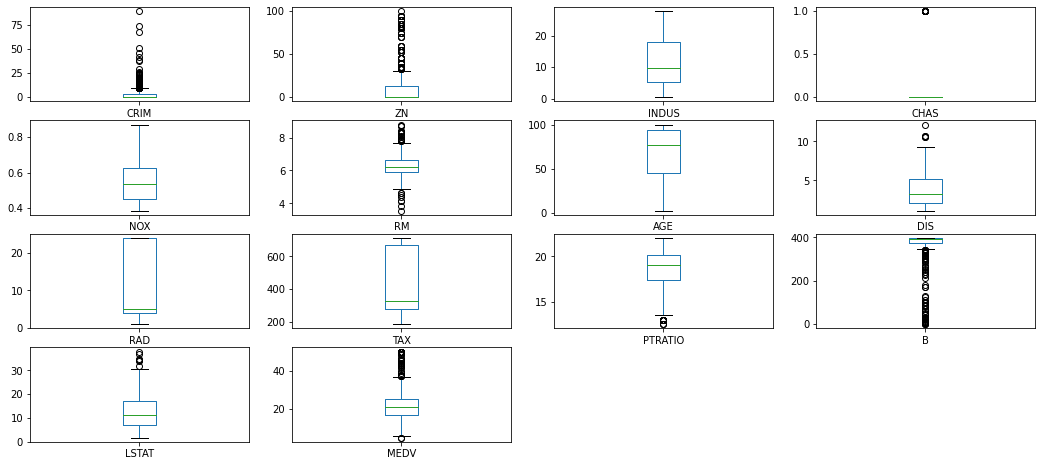

In [11]:
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(18, 8))

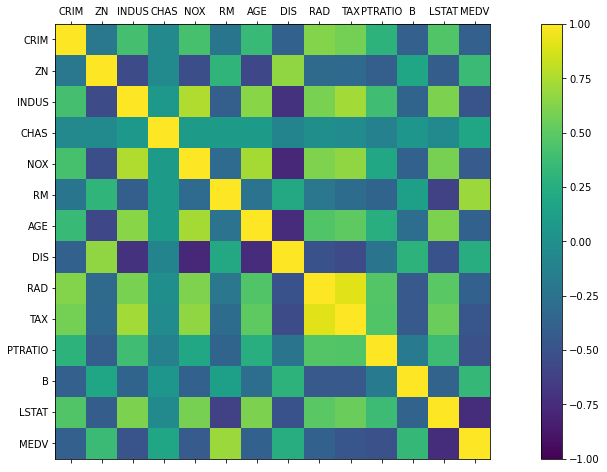

In [12]:
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

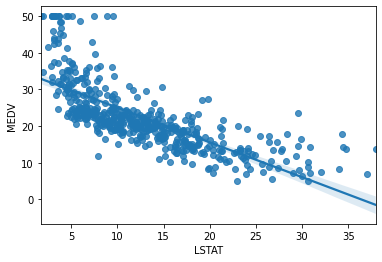

In [32]:
fig = sns.regplot(x=df['LSTAT'], y=df['MEDV'], data=df)

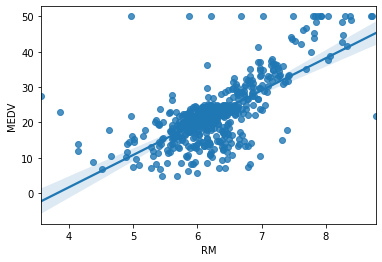

In [26]:
fig = sns.regplot(x=df['RM'], y=df['MEDV'], data=df)

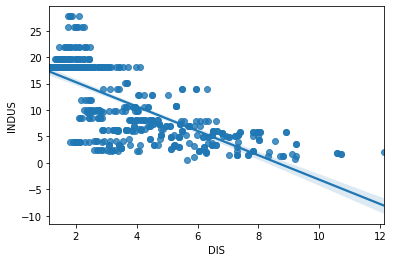

In [30]:
fig = sns.regplot(x=df['DIS'], y=df['INDUS'], data=df)

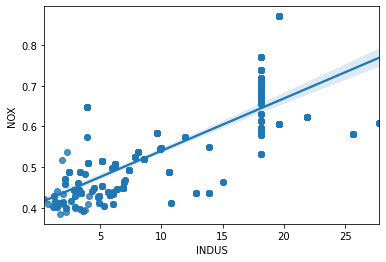

In [35]:
fig = sns.regplot(x=df['INDUS'], y=df['NOX'], data=df)

In [ ]:
fig = sns.regplot(x=df['DIS'], y=df['INDUS'], data=df)

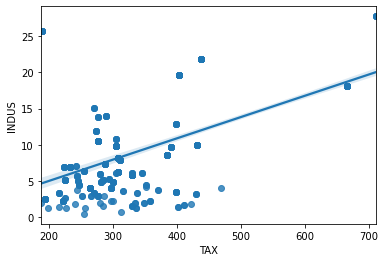

In [36]:
fig = sns.regplot(x=df['TAX'], y=df['INDUS'], data=df)

#### Prepare Data

In [37]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

#### Split-out validation dataset

In [65]:
array = df.values
X = array[:, 0:13]
Y = array[:, 13]
validation_size = 0.20
seed = 7
X_train, X_validation, y_train, y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#### Evaluate Algorithms

In [66]:
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

#### Spot Check Algorithms

In [67]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='auto'))])))

#### Evaluate each model in turn

In [68]:
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -22.006009 (12.188886)
ScaledLASSO: -27.205896 (12.124418)
ScaledEN: -28.301160 (13.609110)
ScaledKNN: -21.456867 (15.016218)
ScaledCART: -24.840917 (16.718973)
ScaledSVR: -29.570433 (18.052964)


#### Compare Algorithms

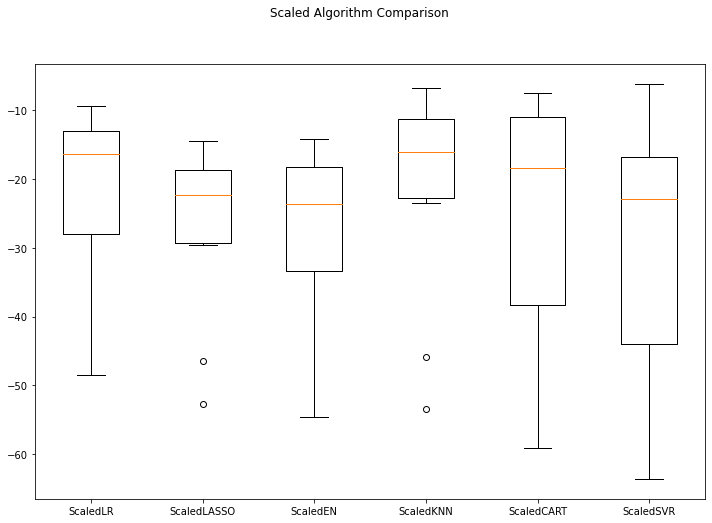

In [69]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### KNN Algorithm tuning

In [70]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -19.532921 using {'n_neighbors': 1}
-19.532921 (15.809604) with: {'n_neighbors': 1}
-19.976746 (13.845123) with: {'n_neighbors': 3}
-21.270695 (14.877693) with: {'n_neighbors': 5}
-21.595627 (15.016710) with: {'n_neighbors': 7}
-21.021208 (14.769371) with: {'n_neighbors': 9}
-21.507995 (14.939525) with: {'n_neighbors': 11}
-21.280531 (14.522987) with: {'n_neighbors': 13}
-21.975913 (14.273897) with: {'n_neighbors': 15}
-22.746000 (14.553729) with: {'n_neighbors': 17}
-23.511412 (14.961989) with: {'n_neighbors': 19}
-24.241155 (15.212979) with: {'n_neighbors': 21}


c:\users\common\anaconda3\envs\ml-cpu-sk.0.21.2\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### Spot Check ensembes Algorithms

In [71]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))

#### Evaluate each ensemble model in turn

In [73]:
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -15.218198 (7.923323)
ScaledGBM: -10.892644 (8.613679)
ScaledRF: -14.839357 (11.092954)
ScaledET: -10.131009 (6.010970)


#### Compare ensemble Algorithms

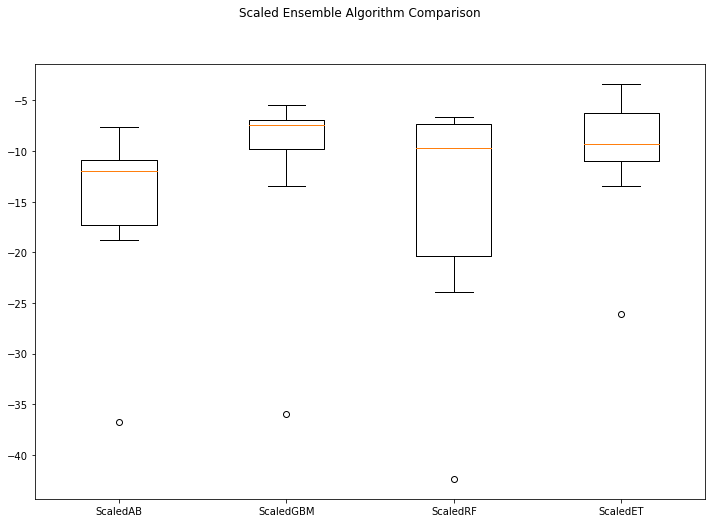

In [74]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Tune scaled GBM

In [76]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50, 100, 150, 200, 250, 300, 350, 400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -10.635387 using {'n_estimators': 400}
-11.704630 (8.888674) with: {'n_estimators': 50}
-11.154807 (8.824873) with: {'n_estimators': 100}
-10.912850 (8.789134) with: {'n_estimators': 150}
-10.860327 (8.709971) with: {'n_estimators': 200}
-10.730523 (8.592555) with: {'n_estimators': 250}
-10.724569 (8.549616) with: {'n_estimators': 300}
-10.663613 (8.465758) with: {'n_estimators': 350}
-10.635387 (8.404994) with: {'n_estimators': 400}


#### Make predictions on validation dataset

#### prepare the model

In [77]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=400)
model.fit(rescaledX, Y_train)
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))

11.878916447820348
